<a href="https://colab.research.google.com/github/jlonge4/gen_ai_utils/blob/main/flux_kontext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating FLUX.1-Kontext Inference with `torch.compile` and EFS Caching

This notebook demonstrates how to significantly reduce inference time for the FLUX.1-Kontext model using `torch.compile`. By compiling the model, we can achieve a performance improvement, reducing the inference time from approximately 30 seconds to around 20 seconds.

Furthermore, for deployments in environments like SageMaker where multiple instances might be used, we can leverage Amazon Elastic File System (EFS) to persist compilation artifacts across instances. This allows subsequent instances to use the cached compiled graph without needing to recompile, saving valuable setup time and improving scaling efficiency.

## Compilation with `torch.compile`

The `torch.compile` function is a powerful tool in PyTorch that optimizes your model for faster execution. It works by analyzing your model's code and applying various optimizations, such as kernel fusion and graph simplification, to reduce overhead and improve performance on your target hardware.

In this notebook, we apply `torch.compile` to the `transformer` and `vae.decode` components of the `FluxKontextPipeline` to accelerate the inference process.

## EFS-Based Persistent Caching for SageMaker

When deploying models to scalable environments like SageMaker, recompiling the model on every new instance can be time-consuming. By mounting an EFS volume and configuring environment variables, we can direct the compilation caches to the persistent storage. This allows multiple instances to share the same compiled artifacts, eliminating the need for recompilation and enabling faster scaling.

The following code snippet illustrates how you can compile the FluxKontext pipeline to cut inference time by 33%.

References:
- https://modal.com/blog/flux-3x-faster

- https://huggingface.co/docs/diffusers/en/optimization/fp16#fused-projection-matrices

- https://github.com/modal-labs/modal-examples/blob/b5fbb047905382a611cb21d45aa6ddd631a1f15d/misc/flux_endpoint.py

In [1]:
# Install diffusers from the main branch until future stable release
!pip install git+https://github.com/huggingface/diffusers.git
!pip install git+https://github.com/chengzeyi/ParaAttention.git

In [ ]:
!nvidia-smi

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image

pipe = FluxKontextPipeline.from_pretrained("black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16)
pipe.to("cuda")

In [2]:
input_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

In [ ]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]


Compile graphs (takes approx 15 min)

In [ ]:
# The order of events here matters
from para_attn.first_block_cache.diffusers_adapters import apply_cache_on_pipe

torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_check_all_directions = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.disable_progress = False
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.shape_padding = True

apply_cache_on_pipe(
    pipe,
    residual_diff_threshold=0.08,
)

pipe.transformer.fuse_qkv_projections()
pipe.vae.fuse_qkv_projections()
pipe.transformer.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

# Mark layers for compilation with dynamic shapes enabled.
pipe.transformer = torch.compile(
    pipe.transformer, mode="max-autotune-no-cudagraphs"
)
pipe.vae.decode = torch.compile(
    pipe.vae.decode, mode="max-autotune-no-cudagraphs"
)

# kickoff compilation
pipe(
  image=input_image,
  prompt="Add a hat to the cat",
)

In [ ]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]

In [ ]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]

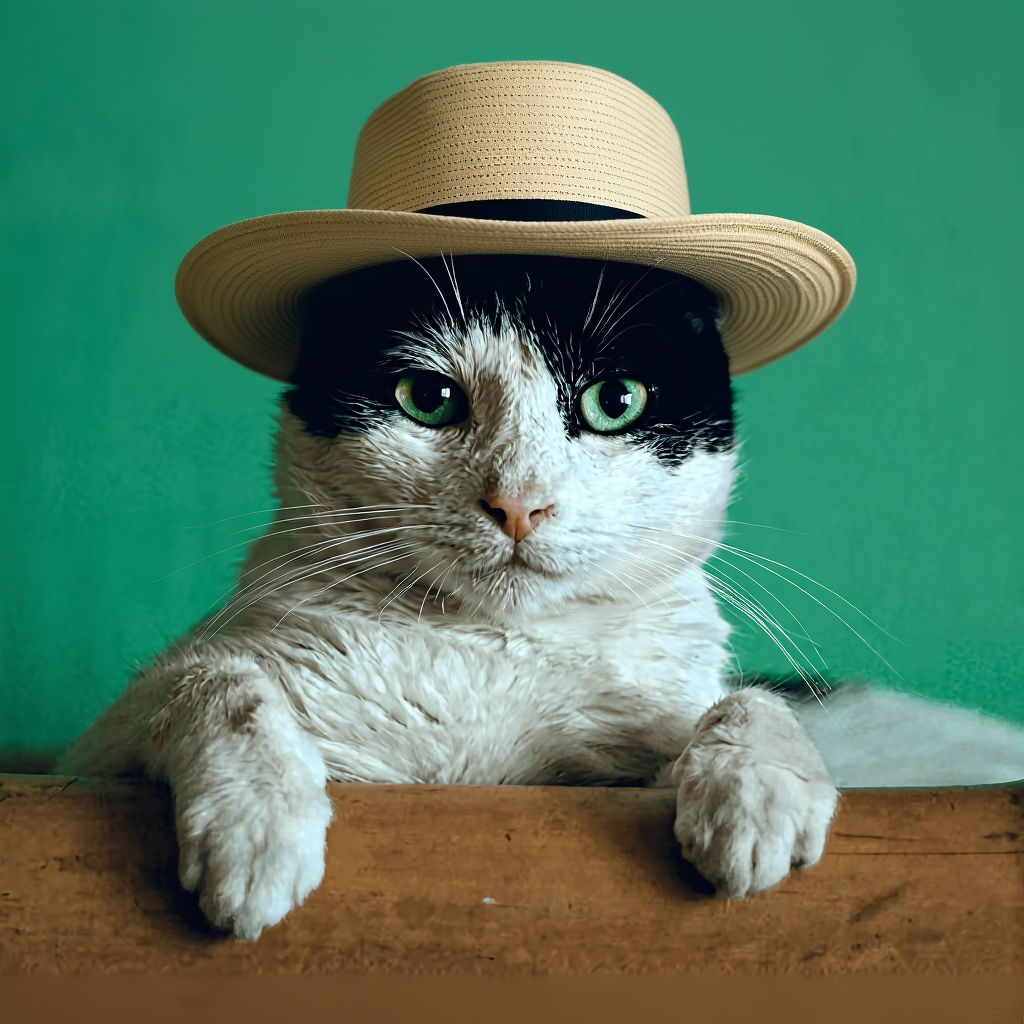

In [8]:
from IPython.display import display
display(image)